## Miscellanious paper analysis things

for stuff that I couldn't find room for anywhere else

### Measuring Network Locality 

Shows for a given network how the size of the receptive field changes as a function of the denoising step

In [ ]:
# helper functions :)
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
plt.rcParams["font.family"] = "Times New Roman"

obs_dim = 2
def sample_gradient_images(agent,config):
    agent.eval()

    fix_mask = agent.fix_mask
    fix_mask = fix_mask * 0.0
    fix_mask[:,0, :] = 1. # for the starting/current state
    agent.fix_mask = fix_mask # for ending state
    state_history = [[[-0.96 , 0.96]]]
    history_len = min(len(state_history),config.memory)
    state_history_array = torch.tensor(np.array(state_history),device=config.device) # shape (len(state_history), n_envs, obs_dim)
    state_history_array = state_history_array[-history_len:] # shape (history_len,n_envs,obs_dim)
    state_history_array = torch.transpose(state_history_array,0,1)
    prior = torch.zeros((config.num_envs, config.gen_horizon, obs_dim), device=config.device) # size (num_envs, config.horizon, obs_dim)

    prior[:, :history_len, :] = state_history_array#[:,-history_len:,:] # inpaints start state at beginning of trajectory


    traj, log = agent.sample(
        prior,
        solver='ddpm',
        n_samples=config.num_envs,
        sample_steps=config.sampling_steps,
        use_ema=config.use_ema, 
        w_cg=config.w_cg, 
        temperature=config.temperature,
        requires_grad=True,
        preserve_history=True)
    
    #print(log['grad_history'].shape)
    #fig, ax = plt.subplots(figsize=(6, 6),dpi=400)

    # should be shape ~500, ~100
    gradient_image = np.nan_to_num(np.abs(np.squeeze(log['grad_history'],(0,2))[1:,1:,0].T))
    return gradient_image
def plot_gradient_images(gradient_image,title=''):
    fig, ax = plt.subplots(dpi=400)
    plt.imshow(gradient_image,aspect=1/5,cmap=mpl.colormaps['cividis'])
    plt.title(title,size=27)
    #plt.colorbar()
    plt.xlabel('DDPM Step',size=27)
    plt.ylabel('Trajectory Gradient',size=27)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=0,size=0)
    

In [ ]:
# Loads Unconditional Base Model 
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = JannerUNet1d(
obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
use_timestep_emb=config.use_timestep_embeddings)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

agent.load('paper_models/DP-UNet-gridland-n5-37166c54diffusion_ckpt_latest.pt')



model = agent.model['diffusion']

In [ ]:
grad_image_unet = 0
for i in range(25):
    grad_image_unet += sample_gradient_images(agent,config)
grad_image_unet /= 25
plot_gradient_images(grad_image_unet,title='U-Net')

In [ ]:
# Loads Unconditional Base Model w/ Data Augmentation
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = JannerUNet1d(
obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
use_timestep_emb=config.use_timestep_embeddings)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)
agent.load('paper_models/DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_latest.pt')
model = agent.model['diffusion']

In [ ]:
# Loads Eq-Net w/positional augmentation
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
config.add_positional_encoding = True
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position = config.add_positional_encoding)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)
agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')

In [ ]:
# Loads normal Eq-Net
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
config.add_positional_encoding = False
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position = config.add_positional_encoding)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)
agent.load('paper_models/DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_latest.pt')

In [ ]:
grad_image_eqnet = 0
for i in range(25):
    grad_image_eqnet += sample_gradient_images(agent,config)
grad_image_eqnet /= 25
plot_gradient_images(grad_image_eqnet,title='Eq-Net')

In [ ]:
plot_gradient_images(grad_image_eqnet[:,0:99],title='Eq-Net')

In [ ]:
percentile = 45
color_thing = mpl.colormaps['viridis']
windows_unet = []
print(grad_image_unet.shape)
for ddm_step_index in range(grad_image_unet.shape[1]-1):
    trajectory_gradient = grad_image_unet[:,ddm_step_index]
    sorted_gradients = np.sort(trajectory_gradient) # no does low to high
    #threshold_value = sorted_gradients[450] # this doesn't really make sense
    threshold_value = np.percentile(grad_image_unet.flatten(),percentile)
    low_index = 0
    high_index = 510
    found_low = False
    found_high = False
    # finds lowest value
    while not found_low:
        if trajectory_gradient[low_index] > threshold_value or low_index == 256:
            found_low = True
        else:
            low_index += 1

    while not found_high:
        if trajectory_gradient[high_index] > threshold_value or high_index ==  256:
            found_high = True
        else:
            high_index -= 1
    windows_unet.append(high_index-low_index)
windows_unet = np.array(windows_unet)
windows_eqnet = []
print(grad_image_eqnet[:,0:99].shape)
for ddm_step_index in range(grad_image_eqnet[:,0:99].shape[1]-1):
    trajectory_gradient = grad_image_eqnet[:,0:99][:,ddm_step_index]
    sorted_gradients = np.sort(trajectory_gradient) # no does low to high
    #threshold_value = sorted_gradients[450] # this doesn't really make sense
    threshold_value = np.percentile(grad_image_eqnet[:,0:99].flatten(),percentile)
    low_index = 0
    high_index = 510
    found_low = False
    found_high = False
    # finds lowest value
    while not found_low:
        if trajectory_gradient[low_index] > threshold_value or low_index == 256:
            found_low = True
        else:
            low_index += 1

    while not found_high:
        if trajectory_gradient[high_index] > threshold_value or high_index ==  256:
            found_high = True
        else:
            high_index -= 1
    windows_eqnet.append(high_index-low_index)
windows_eqnet = np.array(windows_eqnet)
plt.plot(windows_eqnet,label='eqnet')
plt.plot(windows_unet,label='unet')
plt.legend()

In [ ]:
from scipy.signal import savgol_filter
fig, ax = plt.subplots(dpi=400,figsize=(7,4))
names = ['U-Net','Eq-Net']
grad_images = [grad_image_unet[:,0:99],grad_image_eqnet[:,0:99]]
percentile = 75
unet_windows = []
color_thing = mpl.colormaps['viridis']
for thing in grad_images:
    grad_image_unet = thing[:513,:]
    windows_unet = []
    #print(grad_image_unet.shape)
    for ddm_step_index in range(grad_image_unet.shape[1]-1):
        trajectory_gradient = grad_image_unet[:,ddm_step_index]
        sorted_gradients = np.sort(trajectory_gradient) # no does low to high
        #threshold_value = sorted_gradients[450] # this doesn't really make sense
        threshold_value = np.percentile(grad_image_unet.flatten(),percentile)
        low_index = 0
        high_index = 510
        found_low = False
        found_high = False
        # finds lowest value
        while not found_low:
            if trajectory_gradient[low_index] > threshold_value or low_index == 256:
                found_low = True
            else:
                low_index += 1

        while not found_high:
            if trajectory_gradient[high_index] > threshold_value or high_index ==  256:
                found_high = True
            else:
                high_index -= 1
        windows_unet.append(high_index-low_index)
    windows_unet = np.array(windows_unet)
    unet_windows.append(windows_unet)

for i,window in enumerate(unet_windows):
    smooth_window = savgol_filter(window, 30, 2)
    plt.plot(smooth_window,label=names[i],c=color_thing(i*.7))
plt.legend(fontsize=15)

plt.ylabel('Receptive Field Size [Pixels]',size=15)
plt.xlabel('DDPM Step',size=15)
plt.title('Architecture vs Receptive Field Size',size=20)

In [ ]:
plt.scatter(traj[0,:,0].detach().cpu().numpy(),traj[0,:,1].detach().cpu().numpy())

In [ ]:
# Loads large Eq-Net
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
config.add_positional_encoding = False
config.kernel_expansion_rate = 2
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position = config.add_positional_encoding)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)
agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

In [ ]:
grad_image_eqnet_large = 0
for i in range(50):
    grad_image_eqnet_large += sample_gradient_images(agent,config)
grad_image_eqnet_large /= 50
plot_gradient_images(grad_image_eqnet_large,title='Eq-Net Large Kernel')

In [ ]:
plot_gradient_images(grad_image_eqnet_large[:,0:99],title='Eq-Net Large')

In [ ]:
# Loads smol Eq-Net
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
config.add_positional_encoding = False
config.kernel_expansion_rate = 12
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position = config.add_positional_encoding)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)
agent.load('appendix_models/DP-EqNet-KS-gridland-n5-6d8809c9diffusion_ckpt_latest.pt')

In [ ]:
from tqdm import trange
grad_image_eqnet_small = 0
for i in trange(50):
    grad_image_eqnet_small += sample_gradient_images(agent,config)
grad_image_eqnet_small /= 50
plot_gradient_images(grad_image_eqnet_small,title='Eq-Net Large Kernel')

In [ ]:
plot_gradient_images(grad_image_eqnet_small[:,0:99],title='Eq-Net Large Small')

### Measuring Positional Equivariance

Shows for a given network how much the network's predictions vary when the input is shifted


In [33]:
# Loads normal Eq-Net
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
config.add_positional_encoding = False
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position = config.add_positional_encoding)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)
agent.load('paper_models/DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_latest.pt')

model = agent.model['diffusion']

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

In [43]:
# Loads Unconditional Base Model 
import numpy as np
import torch
import matplotlib.pyplot as plt
from diffusion_planner import DiffusionPlannerConfig
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE

from utilities.cleandiffuser.nn_diffusion import CNN1dShiftEq,JannerUNet1d
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.num_envs = 1
obs_dim = 2
# loads model and shit for JannerUNet
nn_diffusion = JannerUNet1d(
obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
use_timestep_emb=config.use_timestep_embeddings)
classifier = None
nn_condition = None
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

agent.load('paper_models/DP-UNet-gridland-n5-37166c54diffusion_ckpt_latest.pt')



model = agent.model['diffusion']

In [44]:
examined_window_size = 50
normal_noise = torch.normal(0,1,(1,examined_window_size,2),device="cuda")*10

Text(0.5, 1.0, 'U-Net')

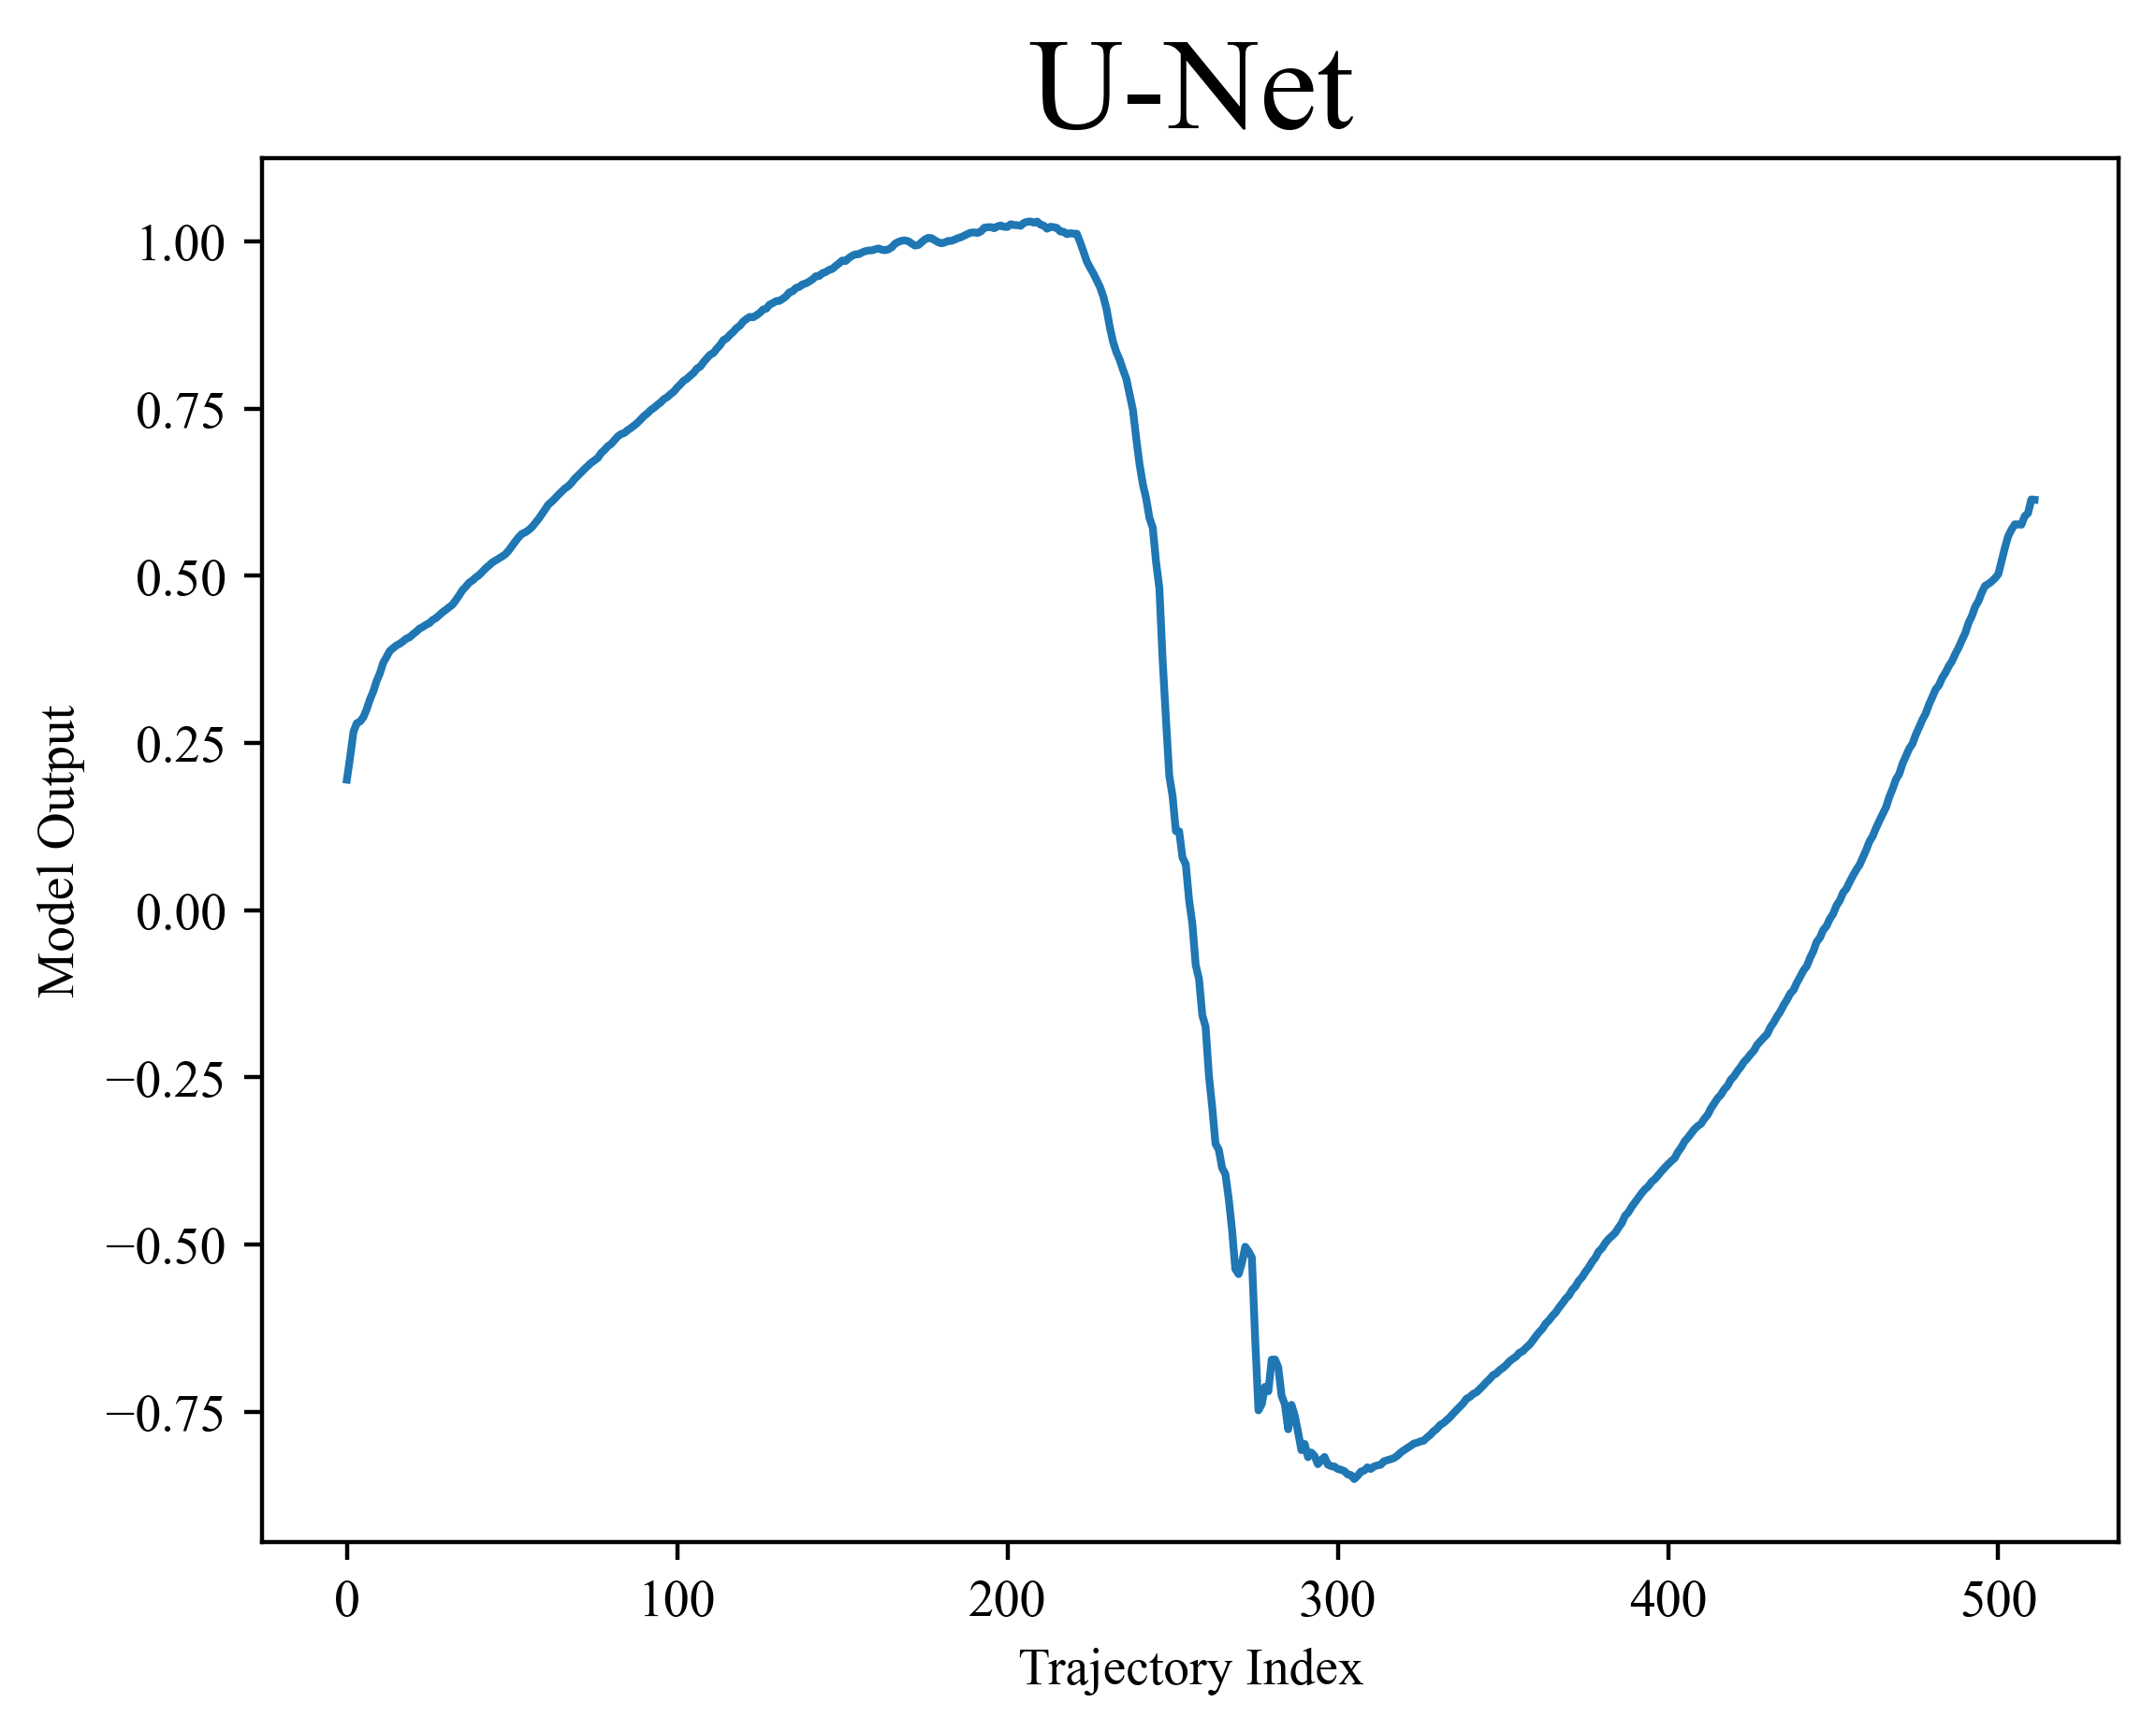

In [47]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(dpi=400,)

examined_window_size = 50
base_index = 270
fake_batch = torch.zeros((1,512,2),device="cuda")
fake_batch_2 = torch.zeros((1,512,2),device="cuda")
#fake_batch_mod = torch.clone(fake_batch)
fake_batch[:,base_index-(examined_window_size//2):base_index+(examined_window_size//2),:] = normal_noise
fake_batch_2[:,base_index+40-(examined_window_size//2):base_index+40+(examined_window_size//2),:] = normal_noise

#fake_batch = fake_batch.permute(0, 2, 1)
out = model(fake_batch,torch.tensor([0],device='cuda'),None)
out_2 = model(fake_batch_2,torch.tensor([0],device='cuda'),None)

original_sample = out.detach().cpu().numpy()

plt.plot(original_sample[0,:,0])
plt.xlabel('Trajectory Index',)
plt.ylabel('Model Output',)
plt.title('U-Net',fontsize=25)

Text(0.5, 1.0, 'U-Net')

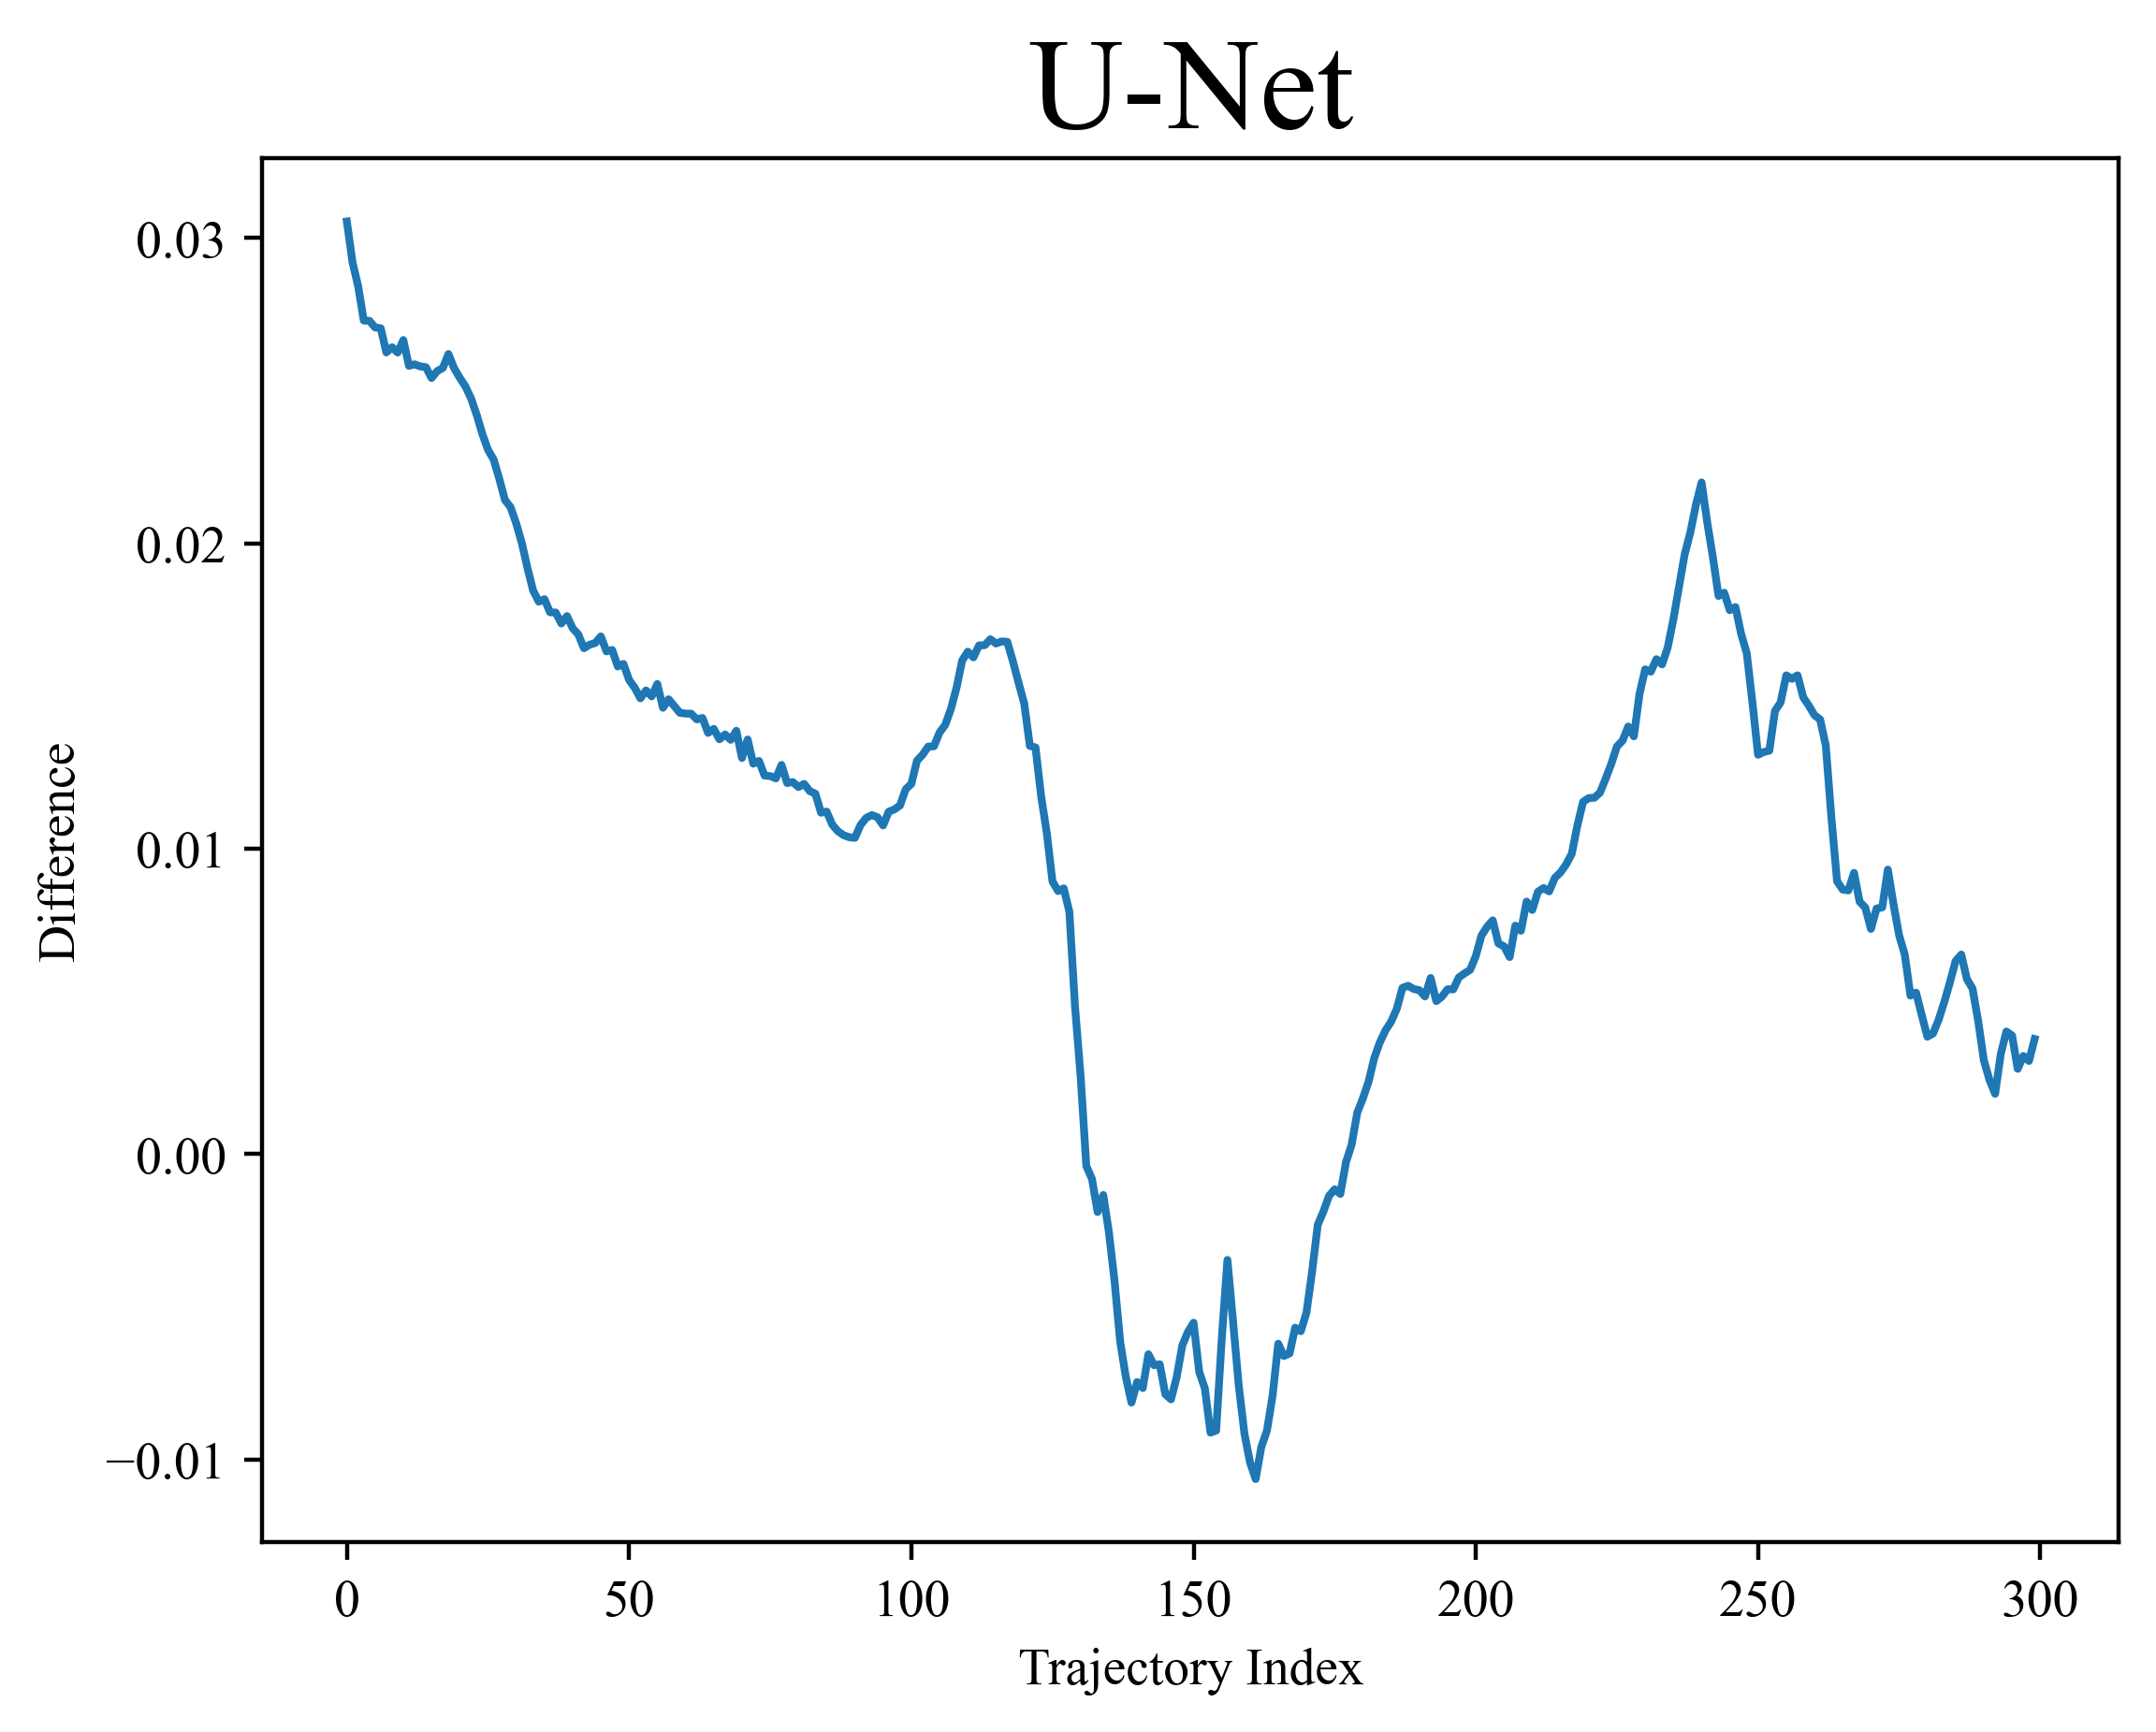

In [46]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(dpi=400,)

original_sample = out.detach().cpu().numpy()
original_sample_2 = out_2.detach().cpu().numpy()
plt.plot((original_sample_2[0,120:420]-original_sample[0,80:380])[:,0])
plt.xlabel('Trajectory Index',)
plt.ylabel('Difference',)
plt.title('U-Net',fontsize=25)

In [ ]:
error_store = []
from tqdm import trange
for i in trange(10):
    examined_window_size = 26
    base_index = 26
    fake_batch = torch.zeros((1,512,2),device="cuda")
    normal_noise = torch.normal(0,1,(1,examined_window_size,2),device="cuda")

    fake_batch[:,base_index-(examined_window_size//2):base_index+(examined_window_size//2),:] = normal_noise
    #fake_batch = fake_batch.permute(0, 2, 1)
    out = model(fake_batch,torch.tensor([0],device='cuda'),None)
    original_sample = out.detach().cpu().numpy()
    error = 0
    score_thing = 0
    for i in range(examined_window_size):
        offset = i-(examined_window_size//2)+base_index
    #fake_batch = torch.normal(0,1,(1,512,2),device="cuda")
        fake_batch = torch.zeros((1,512,2),device="cuda")
    #fake_batch_mod = torch.clone(fake_batch)
        fake_batch[:,offset-(examined_window_size//2):offset+(examined_window_size//2),:] = normal_noise

        #fake_batch = fake_batch.permute(0, 2, 1)
        out = model(fake_batch,torch.tensor([0],device='cuda'),None).detach().cpu().numpy()
        error += np.linalg.norm(original_sample[:,offset-(examined_window_size//2):offset+(examined_window_size//2),:]-
                            out[:,offset-(examined_window_size//2):offset+(examined_window_size//2),:])
    #out.permute(0, 2, 1)
    error /= examined_window_size
    error_store.append(error)
print('Average:',np.average(error_store))
print('variance',np.var(error_store))

In [ ]:
fake_batch = torch.normal(0,1,(1,512,2),device="cuda")
normal_noise = torch.normal(0,1,(1,100,2),device="cuda")


In [ ]:
examined_window_size = 50
base_index = 52
fake_batch = torch.zeros((1,512,2),device="cuda")
#fake_batch_mod = torch.clone(fake_batch)
fake_batch[:,base_index-(examined_window_size//2):base_index+(examined_window_size//2),:] = normal_noise
#fake_batch = fake_batch.permute(0, 2, 1)
out = model(fake_batch,torch.tensor([0],device='cuda'),None)
original_sample = out.detach().cpu().numpy()

plt.plot(original_sample[0,:,0])